In [6]:
# =============================================================
# 0. IMPORTS + GLOBAL SEED
# =============================================================
import os
import gc
import random
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, log_loss, f1_score
)

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

try:
    import tensorflow as tf
    tf.random.set_seed(SEED)
except:
    pass

In [27]:
# ===============================
# GLOBAL PLOT STYLE (CONSISTENT)
# ===============================
import matplotlib.pyplot as plt
import numpy as np

def set_plot_style():
    plt.rcParams.update({
        "figure.figsize": (8, 6),
        "figure.dpi": 120,
        "font.size": 12,
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "legend.fontsize": 11,
        "axes.grid": True,
        "grid.alpha": 0.3,
        "lines.linewidth": 2
    })


In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    # Hitung confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    
    # Membuat Heatmap
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",            # Format angka integer (tanpa koma)
        cmap="Blues",       # GANTI WARNA: Menggunakan tema Biru sesuai gambar
        cbar=True,          # GANTI DESIGN: Menampilkan color bar di samping kanan
        xticklabels=["Benign (0)", "Attack (1)"], # Label bawah (Prediksi)
        yticklabels=["Benign (0)", "Attack (1)"], # Label samping (Aktual)
        annot_kws={"size": 14} # Ukuran font angka di dalam kotak
    )

    plt.title(title, fontsize=16, pad=20)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("Actual Label", fontsize=12)
    plt.tight_layout()
    plt.show()

In [29]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_prob, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


In [30]:
import matplotlib.pyplot as plt

def plot_learning_curve(history, model_name="Model"):
    """
    Plot hanya Loss dan Accuracy (Standar Learning Curve).
    """
    
    # Ambil data dari history
    loss = history.history['loss']
    val_loss = history.history.get('val_loss')
    
    acc = history.history.get('accuracy')
    val_acc = history.history.get('val_accuracy')
    
    epochs = range(1, len(loss) + 1)
    
    # Setup Figure (Ukuran disesuaikan untuk 2 grafik)
    plt.figure(figsize=(12, 5))

    # --- 1. LOSS CURVE ---
    plt.subplot(1, 2, 1) # 1 Baris, 2 Kolom, Grafik ke-1
    plt.plot(epochs, loss, label='Train Loss')
    if val_loss:
        plt.plot(epochs, val_loss, label='Val Loss')
    plt.title(f'{model_name} - Loss Analysis')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # --- 2. ACCURACY CURVE ---
    if acc:
        plt.subplot(1, 2, 2) # 1 Baris, 2 Kolom, Grafik ke-2
        plt.plot(epochs, acc, label='Train Accuracy')
        if val_acc:
            plt.plot(epochs, val_acc, label='Val Accuracy')
        plt.title(f'{model_name} - Accuracy Analysis')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()




In [7]:
# =============================================================
# 1. LOAD DATASET
# =============================================================
print("\n📂 Loading Dataset Binary...")

joblib_path = r"D:\bismillah\binary_dataset.joblib"

if not os.path.exists(joblib_path):
    raise FileNotFoundError(f"Dataset not found at {joblib_path}")

data_pack = joblib.load(joblib_path)

X_train = np.array(data_pack["X_train"], dtype=np.float32)
y_train = np.array(data_pack["y_train"]).astype(int)

X_val   = np.array(data_pack["X_val"], dtype=np.float32)
y_val   = np.array(data_pack["y_val"]).astype(int)

X_test  = np.array(data_pack["X_test"], dtype=np.float32)
y_test  = np.array(data_pack["y_test"]).astype(int)

del data_pack
gc.collect()

print(f"✅ Data Loaded: Train={X_train.shape}, Val={X_val.shape}, Test={X_test.shape}")


📂 Loading Dataset Binary...
✅ Data Loaded: Train=(1764525, 43), Val=(378113, 43), Test=(378113, 43)


In [8]:
# =============================================================
# 2. STANDARD SCALING (PALING STABIL)
# =============================================================
print("\n🔧 Scaling features using StandardScaler...")

scaler = StandardScaler()
scaler.fit(X_train)

X_train_s = scaler.transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

print("✅ Scaling done.")


🔧 Scaling features using StandardScaler...
✅ Scaling done.


In [9]:
# =============================================================
# 3. TRAIN OPTIMAL RANDOM FOREST TEACHER
# =============================================================
print("\n🌲 Training Optimized Random Forest Teacher...")

rf = RandomForestClassifier(
    n_estimators=700,
    max_depth=20,
    min_samples_leaf=2,
    min_samples_split=4,
    max_features="sqrt",
    bootstrap=True,
    class_weight="balanced_subsample",
    random_state=SEED,
    n_jobs=-1
)

rf.fit(X_train_s, y_train)

print("\n📊 Teacher Evaluation (Validation):")
pred_val = rf.predict(X_val_s)
print(classification_report(y_val, pred_val, digits=6))

# Soft labels
teacher_train_probs = rf.predict_proba(X_train_s)[:, 1].astype(np.float32)
teacher_val_probs   = rf.predict_proba(X_val_s)[:, 1].astype(np.float32)


🌲 Training Optimized Random Forest Teacher...

📊 Teacher Evaluation (Validation):
              precision    recall  f1-score   support

           0   0.999672  0.999029  0.999351    314259
           1   0.995239  0.998387  0.996810     63854

    accuracy                       0.998921    378113
   macro avg   0.997455  0.998708  0.998080    378113
weighted avg   0.998923  0.998921  0.998922    378113



In [10]:
# =============================================================
# 4. DISTILLATION SOFTENING (ALPHA & TEMPERATURE)
# =============================================================
alpha = 0.6     # best for CIC IDS
T     = 1.5     # softer, but not too soft

def soften(p, T):
    return np.power(p, 1/T).astype(np.float32)

teacher_train_soft = soften(teacher_train_probs, T)
teacher_val_soft   = soften(teacher_val_probs, T)

In [11]:
# # =============================================================
# # 5. BUILD STUDENT NN (STABLE VERSION)
# # =============================================================
# print("\n🧠 Building Student NN with StandardScaler Preprocess...")

# from tensorflow.keras import layers, models


# num_features = X_train.shape[1]

# # convert scaler to TF constants
# mean_tf  = tf.constant(scaler.mean_, dtype=tf.float32)
# scale_tf = tf.constant(np.sqrt(scaler.var_), dtype=tf.float32)

# def standard_preprocess(x):
#     x = tf.cast(x, tf.float32)
#     return (x - mean_tf) / scale_tf

# inputs = layers.Input(shape=(num_features,), dtype=tf.float32)
# x = layers.Lambda(standard_preprocess)(inputs)

# # BLOCK 1
# x = layers.Dense(128, activation="relu")(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.20)(x)

# # BLOCK 2
# x = layers.Dense(64, activation="relu")(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.15)(x)

# # BLOCK 3
# x = layers.Dense(32, activation="relu")(x)
# x = layers.Dropout(0.10)(x)

# outputs = layers.Dense(1, activation="sigmoid")(x)

# student = models.Model(inputs, outputs, name="snort_student")

# student.compile(
#     optimizer=tf.keras.optimizers.Adam(1e-4),
#     loss="binary_crossentropy"
# )

# student.summary()

In [12]:
# =============================================================
# 5. BUILD STUDENT NN (PRODUCTION-SAFE VERSION)
# =============================================================
print("\n🧠 Building Student NN with Normalization layer...")

import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

num_features = X_train.shape[1]

# -------------------------------------------------------------
# Normalization layer (REPLACE Lambda + custom function)
# -------------------------------------------------------------
norm = layers.Normalization(
    mean=scaler.mean_,
    variance=scaler.var_
)

# -------------------------------------------------------------
# Model definition
# -------------------------------------------------------------
inputs = layers.Input(shape=(num_features,), dtype=tf.float32)
x = norm(inputs)

# BLOCK 1
x = layers.Dense(128, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.20)(x)

# BLOCK 2
x = layers.Dense(64, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.15)(x)

# BLOCK 3
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.10)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

student = models.Model(inputs, outputs, name="snort_student")

student.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy"
)

student.summary()



🧠 Building Student NN with Normalization layer...


Model: "snort_student"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 43)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 43)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,769 (65.50 KB)

 Trainable params: 16,385 (64.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [13]:
# =============================================================
# 6. TRAIN STUDENT MODEL
# =============================================================
print("\n🚀 Training Student NN...")

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.6, patience=3)
]

history = student.fit(
    X_train, teacher_train_soft,
    validation_data=(X_val, teacher_val_soft),
    epochs=40,
    batch_size=512,
    verbose=2
)



🚀 Training Student NN...
Epoch 1/40
3447/3447 - 18s - 5ms/step - loss: 0.1423 - val_loss: 0.0810
Epoch 2/40
3447/3447 - 16s - 5ms/step - loss: 0.0842 - val_loss: 0.0704
Epoch 3/40
3447/3447 - 15s - 4ms/step - loss: 0.0741 - val_loss: 0.0650
Epoch 4/40
3447/3447 - 15s - 4ms/step - loss: 0.0689 - val_loss: 0.0614
Epoch 5/40
3447/3447 - 15s - 4ms/step - loss: 0.0655 - val_loss: 0.0595
Epoch 6/40
3447/3447 - 15s - 4ms/step - loss: 0.0632 - val_loss: 0.0578
Epoch 7/40
3447/3447 - 15s - 4ms/step - loss: 0.0614 - val_loss: 0.0564
Epoch 8/40
3447/3447 - 15s - 4ms/step - loss: 0.0600 - val_loss: 0.0552
Epoch 9/40
3447/3447 - 15s - 4ms/step - loss: 0.0587 - val_loss: 0.0539
Epoch 10/40
3447/3447 - 15s - 4ms/step - loss: 0.0575 - val_loss: 0.0528
Epoch 11/40
3447/3447 - 15s - 4ms/step - loss: 0.0563 - val_loss: 0.0518
Epoch 12/40
3447/3447 - 15s - 4ms/step - loss: 0.0551 - val_loss: 0.0507
Epoch 13/40
3447/3447 - 15s - 4ms/step - loss: 0.0539 - val_loss: 0.0500
Epoch 14/40
3447/3447 - 15s - 4ms/

In [14]:
# =============================================================
# 7. THRESHOLD TUNING (YOUDEN'S J + MIN THRESHOLD)
# =============================================================
print("\n🎯 Computing Best Threshold (Youden's J with Min Bound)...")

from sklearn.metrics import roc_curve

# probabilitas dari student
val_probs = student.predict(X_val, batch_size=2048).ravel()

# hitung ROC
fpr, tpr, thresholds = roc_curve(y_val, val_probs)

# Youden's J statistic
youden_j = tpr - fpr

# threshold terbaik versi Youden
best_idx = np.argmax(youden_j)
best_th_youden = thresholds[best_idx]

# batas minimum operasional IDS
MIN_TH = 0.4
best_th = max(best_th_youden, MIN_TH)

print("🔥 Best Threshold (Youden's J):", best_th_youden)
print("🚀 Final Threshold (Youden + min 0.4):", best_th)



🎯 Computing Best Threshold (Youden's J with Min Bound)...
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
🔥 Best Threshold (Youden's J): 0.24159335
🚀 Final Threshold (Youden + min 0.4): 0.4


In [15]:
# # =============================================================
# # 7. THRESHOLD TUNING (F1 BEST)
# # =============================================================
# print("\n🎯 Computing Best Threshold (F1)...")

# val_probs = student.predict(X_val, batch_size=2048).ravel()

# best_th = 0.5
# best_f1 = -1

# for t in np.linspace(0.05, 0.95, 200):
#     preds = (val_probs >= t).astype(int)
#     f1 = f1_score(y_val, preds)
#     if f1 > best_f1:
#         best_f1 = f1
#         best_th = t

# print("🔥 Best Threshold (F1):", best_th)

In [16]:
# =============================================================
# 8. FINAL TEST EVALUATION
# =============================================================
test_probs = student.predict(X_test, batch_size=2048).ravel()
test_preds = (test_probs >= best_th).astype(int)

print("\n📊 Final Student Test Evaluation:")
print("Accuracy:", accuracy_score(y_test, test_preds))
print(classification_report(y_test, test_preds, digits=6))

185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

📊 Final Student Test Evaluation:
Accuracy: 0.9947766937397021
              precision    recall  f1-score   support

           0   0.998340  0.995370  0.996853    314259
           1   0.977542  0.991856  0.984647     63854

    accuracy                       0.994777    378113
   macro avg   0.987941  0.993613  0.990750    378113
weighted avg   0.994828  0.994777  0.994792    378113



In [17]:
# =============================================================
# 9. EXPORT TFLITE (SNORT READY)
# =============================================================
print("\n📦 Exporting TFLite Model...")

save_dir = "snort_student_savedmodel"
tflite_path = "lokik.tflite"

if os.path.exists(save_dir):
    import shutil
    shutil.rmtree(save_dir)

student.export(save_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(save_dir)
converter.optimizations = []
tflite_model = converter.convert()

with open(tflite_path, "wb") as f:
    f.write(tflite_model)

print("✅ TFLite saved:", tflite_path)


📦 Exporting TFLite Model...
INFO:tensorflow:Assets written to: snort_student_savedmodel\assets


INFO:tensorflow:Assets written to: snort_student_savedmodel\assets


Saved artifact at 'snort_student_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 43), dtype=tf.float32, name='keras_tensor_2')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1751261526736: TensorSpec(shape=(1, 43), dtype=tf.float32, name=None)
  1751261527312: TensorSpec(shape=(1, 43), dtype=tf.float32, name=None)
  1751261517712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1751261527888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1751295486352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1751295491728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1751295485200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1751295476176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1751295485008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1751295486160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1751286384208: TensorSpec

In [18]:
# =============================================================
# 10. VERIFY TFLITE OUTPUT
# =============================================================
print("\n🔍 Verifying TFLite...")

interpreter = tf.lite.Interpreter(model_path=tflite_path)
interpreter.allocate_tensors()

input_info  = interpreter.get_input_details()[0]
output_info = interpreter.get_output_details()[0]

sample = X_test[:64].astype(np.float32)

interpreter.resize_tensor_input(input_info["index"], sample.shape)
interpreter.allocate_tensors()
interpreter.set_tensor(input_info["index"], sample)
interpreter.invoke()

tflite_out = interpreter.get_tensor(output_info["index"]).ravel()
print("Example TFLite Output:", tflite_out[:10])

print("\n🚀 DONE. MODEL STABIL & SIAP PAKAI DI SNORT.")


🔍 Verifying TFLite...
Example TFLite Output: [3.5622919e-03 7.1103382e-04 1.0749395e-06 5.5923639e-03 9.9461168e-01
 5.0521786e-03 6.5809372e-03 1.6412965e-05 2.4696069e-03 2.4077420e-03]

🚀 DONE. MODEL STABIL & SIAP PAKAI DI SNORT.


In [19]:
print(classification_report(y_test, rf.predict(X_test_s), digits=6))


              precision    recall  f1-score   support

           0   0.999688  0.999058  0.999373    314259
           1   0.995379  0.998465  0.996920     63854

    accuracy                       0.998958    378113
   macro avg   0.997533  0.998762  0.998146    378113
weighted avg   0.998960  0.998958  0.998959    378113



In [20]:
from pathlib import Path

BASE_DIR = Path("bismillah\snort_student_savedmodel")
BASE_DIR.mkdir(parents=True, exist_ok=True)

print("📁 Model path:", BASE_DIR.resolve())

📁 Model path: D:\bismillah\bismillah\snort_student_savedmodel


<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
C:\Users\HP\AppData\Local\Temp\ipykernel_20996\302468508.py:3: SyntaxWarning: invalid escape sequence '\s'
  BASE_DIR = Path("bismillah\snort_student_savedmodel")


In [21]:
student_path = BASE_DIR / "kRF.keras"
student.save(student_path)

print("✅ Student saved in Keras format")

✅ Student saved in Keras format


In [22]:
import tensorflow as tf
from pathlib import Path

model_path = Path("bismillah/snort_student_savedmodel/kRF.keras")

print("Exists:", model_path.exists())  # HARUS True

student = tf.keras.models.load_model(
    model_path,
    compile=False
)

print("✅ Student model loaded")


Exists: True
✅ Student model loaded


In [23]:
from keras.saving import register_keras_serializable

@register_keras_serializable(package="Preprocess")
def standard_preprocess(x):
    x = tf.cast(x, tf.float32)
    return (x - mean_tf) / scale_tf


In [24]:
import tensorflow as tf
student = tf.keras.models.load_model(model_path, compile=False)


In [25]:
import tensorflow as tf

student = tf.keras.models.load_model(
    "bismillah\snort_student_savedmodel\kRF.keras",
    compile=False
)

print("✅ Student model loaded (no retraining)")

# Prediksi probabilitas (0–1)
y_pred_prob = student.predict(X_test, batch_size=2048).ravel()

print("Pred shape:", y_pred_prob.shape)

✅ Student model loaded (no retraining)


<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
C:\Users\HP\AppData\Local\Temp\ipykernel_20996\2424228934.py:4: SyntaxWarning: invalid escape sequence '\s'
  "bismillah\snort_student_savedmodel\kRF.keras",


185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Pred shape: (378113,)


In [39]:
def plot_all_evaluation(y_true, y_prob, threshold=0.24159335, model_name="Model", estimator=None, X=None, y=None):
    y_pred = (y_prob >= threshold).astype(int)

In [41]:
def plot_all_evaluation(y_true, y_prob, threshold=0.24159335, model_name="Model", estimator=None, X=None, y=None):
    y_pred_class = (y_prob >= threshold).astype(int)


    # Evaluasi biasa
    plot_confusion_matrix(y_test, y_pred_class)
    plot_roc_curve(y_true, y_prob, title=model_name)
    plot_learning_curve(history, model_name="Student NN (Distilled)")
    

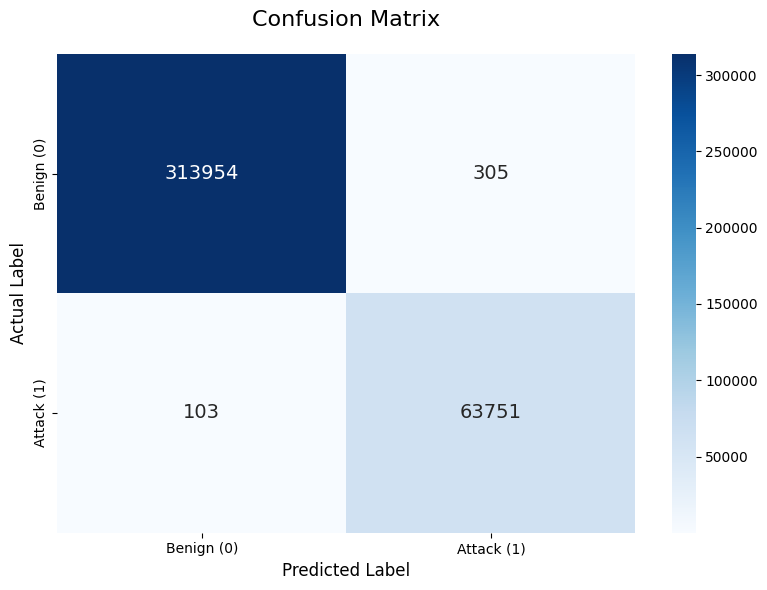

In [48]:
pred_val = rf.predict(X_val_s)
# Evaluasi biasa
plot_confusion_matrix(
    y_true=y_val,
    y_pred=pred_val,

)

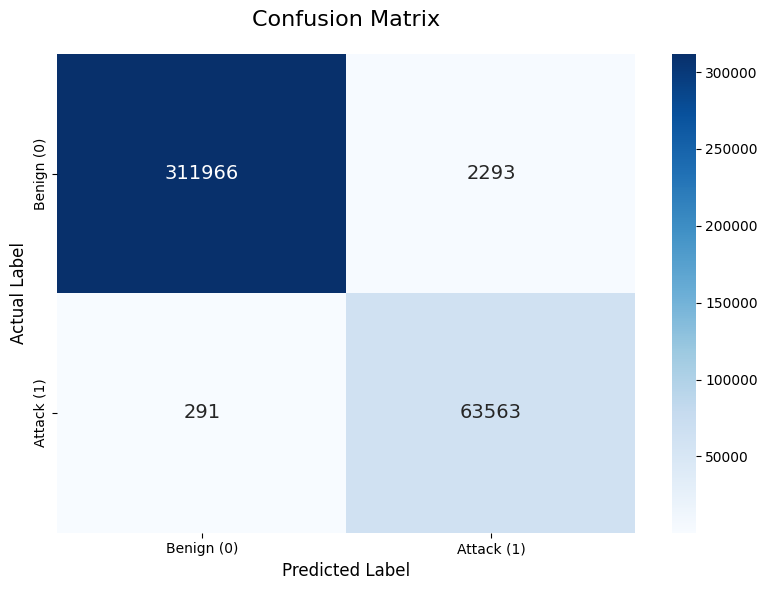

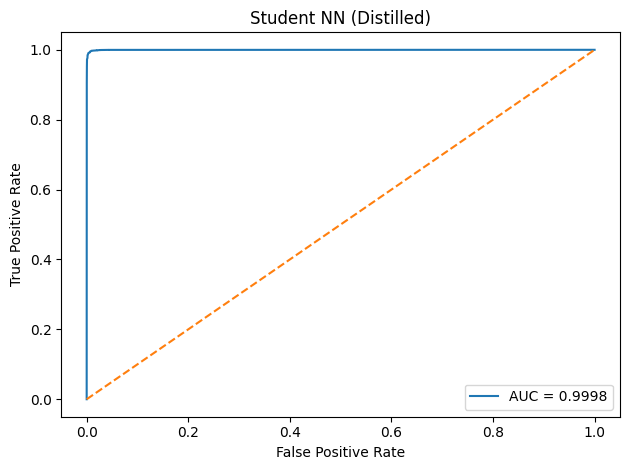

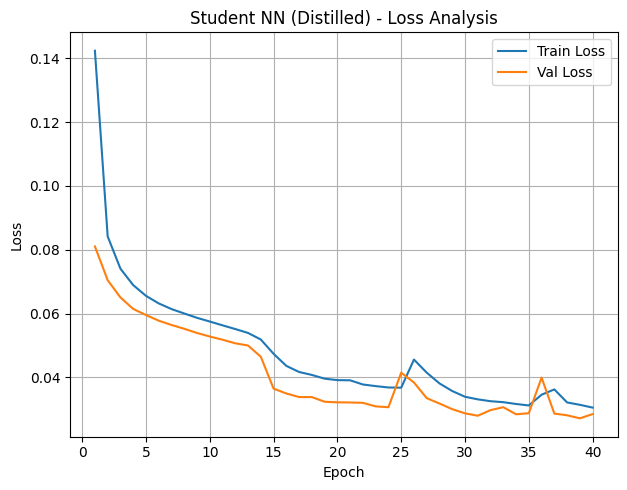

In [42]:
# Evaluasi biasa
plot_all_evaluation(
    y_true=y_test,
    y_prob=y_pred_prob,
    threshold=0.24159335,
    model_name="Student NN (Distilled)"
)


In [ ]:

# =============================================================
# 5. BUILD STUDENT NN (STABLE VERSION)
# =============================================================
print("\n🧠 Building Student NN with StandardScaler Preprocess...")

from tensorflow.keras import layers, models


num_features = X_train.shape[1]

# convert scaler to TF constants
mean_tf  = tf.constant(scaler.mean_, dtype=tf.float32)
scale_tf = tf.constant(np.sqrt(scaler.var_), dtype=tf.float32)

def standard_preprocess(x):
    x = tf.cast(x, tf.float32)
    return (x - mean_tf) / scale_tf

inputs = layers.Input(shape=(num_features,), dtype=tf.float32)
x = layers.Lambda(standard_preprocess)(inputs)

# BLOCK 1
x = layers.Dense(128, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.20)(x)

# BLOCK 2
x = layers.Dense(64, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.15)(x)

# BLOCK 3
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.10)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

student = models.Model(inputs, outputs, name="snort_student")

student.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy"
)

student.summary()


🧠 Building Student NN with StandardScaler Preprocess...



Model: "snort_student"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 43)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 43)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,769 (65.50 KB)

 Trainable params: 16,385 (64.00 KB)

 Non-trainable params: 384 (1.50 KB)